

# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

#Cargar Librerías

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics




## Lectura de datos

In [0]:
# Global data variables

DATA_PATH = "/content/drive/My Drive/2019Q2_DSPF_contents/workshop_spark/data/"

In [0]:
bank = spark.read.csv(DATA_PATH + 'bank-full.csv', sep=';', header=True, inferSchema=True)

#Comprobar correcta lectura de datos

In [0]:
bank.show(5) #visualizamos 5 registros del dataframe

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar|married|  unknow

In [0]:
bank.printSchema() #visualizamos las columnas y tipos del dataframe
                   #el nombre de las variables cumplen con el código de buenas prácticas

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [0]:
bank.dtypes #visualizamos las variables con el formato de datos

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

##Estudiar las dimensiones del dataset

In [0]:
len_original = bank.count(), len(bank.columns)
bank.count(), len(bank.columns)


(45211, 20)

#Data Wrangling

### Cambiar los nombres de las columnas para que cumplan buenas prácticas

In [0]:
bank = bank.withColumnRenamed('y','term_deposit') #la variable objetivo 'y' la renombramos a term_deposit para saber lo que contiene el campo

In [0]:
bank.show(2)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|term_deposit|picked_up_call|extra_info|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----------+
| 58|management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|          no|             1|         1|
| 44|technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|          no|             1|         1|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----

###Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [0]:
#muestro los diferentes tipos de datos que tiene nuestro fichero
tipos=set() 
for col, tipo in bank.dtypes:
  tipos.add(tipo)
tipos



{'int', 'string'}

In [0]:
#Obtenemos para cada variable el nº de valores diferentes que tienen
dicc = {}
for col in bank.columns:
  dicc[col] = bank.select(col).distinct().count()
dicc

{'age': 77,
 'balance': 7168,
 'campaign': 48,
 'contact': 3,
 'day': 31,
 'default': 2,
 'duration': 1573,
 'education': 4,
 'extra_info': 3,
 'housing': 2,
 'job': 12,
 'loan': 2,
 'marital': 3,
 'month': 12,
 'pdays': 559,
 'picked_up_call': 2,
 'poutcome': 4,
 'previous': 41,
 'term_deposit': 2,
 'year': 3}

In [0]:
#mostramos para cada variable el nº de valores que tiene y lo ordenamos descendentemente
for col in bank.columns:
  bank.groupby(col).count().withColumnRenamed('count','total').sort(F.col('total').desc()).show()

+---+-----+
|age|total|
+---+-----+
| 32| 2085|
| 31| 1996|
| 33| 1972|
| 34| 1930|
| 35| 1894|
| 36| 1806|
| 30| 1757|
| 37| 1696|
| 39| 1487|
| 38| 1466|
| 40| 1355|
| 41| 1291|
| 42| 1242|
| 45| 1216|
| 29| 1185|
| 46| 1175|
| 43| 1161|
| 44| 1136|
| 47| 1088|
| 28| 1038|
+---+-----+
only showing top 20 rows

+-------------+-----+
|          job|total|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+

+--------+-----+
| marital|total|
+--------+-----+
| married|27214|
|  single|12790|
|divorced| 5207|
+--------+-----+

+---------+-----+
|education|total|
+---------+-----+
|secondary|23202|
| tertiary|13301|
|  primary| 6851|
|  unknown| 1857|
+---------+-----+

+-------+-----+
|default|total|
+-------+-----+
|     no|44396|
|   

In [0]:
#Pasamos las columnas de día, mes y año a formato fecha en una única columna
bank=bank.withColumn('concat_date',F.concat(F.col('day'),F.col('month'),F.col('year')))
bank.show(3)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----------+-----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|term_deposit|picked_up_call|extra_info|concat_date|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----------+-----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|          no|             1|         1|   5may2008|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|          no|             1|         1|   5may2008|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|  

In [0]:
bank.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('term_deposit', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int'),
 ('concat_date', 'string')]

In [0]:
#La fecha string la convertimos a formato date
bank=bank.withColumn('new_date',F.to_date(F.col('concat_date'),'ddMMMyyyy'))
bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----------+-----------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|term_deposit|picked_up_call|extra_info|concat_date|  new_date|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+------------+--------------+----------+-----------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|          no|             1|         1|   5may2008|2008-05-05|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|          no|             1|         1|   5may2008|2008-05-05|
| 33|entrepreneur| married|sec

In [0]:
bank.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('term_deposit', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int'),
 ('concat_date', 'string'),
 ('new_date', 'date')]

In [0]:
#Eliminamos las variables que hemos utilizado para el concatenar la fecha y el resultado de la fecha string
bank= bank.drop("year",'day','month','concat_date') #Eliminamos la variable
bank.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('term_deposit', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int'),
 ('new_date', 'date')]

### Estudiar si hay registros repetidos

In [0]:
bank.count(), len(bank.columns)

(45211, 18)

In [0]:
bank.distinct().count() #No hay registros duplicados

45211

###Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [0]:
#mostramos para cada variable el nº de valores que tiene y lo ordenamos descendentemente
total_registros=bank.count()
for col in bank.columns:
  contador= bank.groupby(col).count().withColumnRenamed('count','total')
  final = contador.withColumn('pct', F.round((F.col('total')/total_registros)*100)).sort(F.col('pct').desc())
  final.show()

+---+-----+---+
|age|total|pct|
+---+-----+---+
| 32| 2085|5.0|
| 33| 1972|4.0|
| 34| 1930|4.0|
| 37| 1696|4.0|
| 35| 1894|4.0|
| 31| 1996|4.0|
| 30| 1757|4.0|
| 36| 1806|4.0|
| 29| 1185|3.0|
| 39| 1487|3.0|
| 42| 1242|3.0|
| 46| 1175|3.0|
| 43| 1161|3.0|
| 38| 1466|3.0|
| 44| 1136|3.0|
| 41| 1291|3.0|
| 45| 1216|3.0|
| 40| 1355|3.0|
| 55|  806|2.0|
| 26|  805|2.0|
+---+-----+---+
only showing top 20 rows

+-------------+-----+----+
|          job|total| pct|
+-------------+-----+----+
|  blue-collar| 9732|22.0|
|   management| 9458|21.0|
|   technician| 7597|17.0|
|       admin.| 5171|11.0|
|     services| 4154| 9.0|
|      retired| 2264| 5.0|
|self-employed| 1579| 3.0|
| entrepreneur| 1487| 3.0|
|    housemaid| 1240| 3.0|
|   unemployed| 1303| 3.0|
|      student|  938| 2.0|
|      unknown|  288| 1.0|
+-------------+-----+----+

+--------+-----+----+
| marital|total| pct|
+--------+-----+----+
| married|27214|60.0|
|  single|12790|28.0|
|divorced| 5207|12.0|
+--------+-----+----+

+-

In [0]:
#El picked_up_call en un 99,9% cogen el teléfono, por lo que vamos a mirar los 3 casos en los que no se coge el teléfono.
no_atendidos = bank.filter(F.col('picked_up_call') == 0)
no_atendidos.show()

+---+------------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+------------+--------------+----------+----------+
|age|         job|marital|education|default|balance|housing|loan|  contact|duration|campaign|pdays|previous|poutcome|term_deposit|picked_up_call|extra_info|  new_date|
+---+------------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+------------+--------------+----------+----------+
| 72|     retired|married|secondary|     no|   5715|     no|  no| cellular|    1127|       5|  184|       3| success|         yes|             0|         1|2010-11-17|
| 57| blue-collar|married|secondary|     no|    668|     no|  no|telephone|     508|       4|   -1|       0| unknown|          no|             0|         1|2010-11-17|
| 37|entrepreneur|married|secondary|     no|   2971|     no|  no| cellular|     361|       2|  188|      11|   other|          no|             0|         1|2010

In [0]:
#Hemos analizado los valores de term_deposit y de duracion para los 3 casos y los datos obtenidos son incogruentes puesto que no han cogido el teléfono y sin embargo, 
#la duración de la llamada es mayor a 0
no_atendidos.select('term_deposit','duration').distinct().show()

+------------+--------+
|term_deposit|duration|
+------------+--------+
|          no|     508|
|         yes|    1127|
|          no|     361|
+------------+--------+



In [0]:
#Análisis de la variable duration == 0 -> obtenemos 3 registros
dura_0 = bank.filter(F.col('duration') == 0)
dura_0.show()

+---+------------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+------------+--------------+----------+----------+
|age|         job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|term_deposit|picked_up_call|extra_info|  new_date|
+---+------------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+------------+--------------+----------+----------+
| 53|  management|married|  primary|     no|    351|    yes|  no| unknown|       0|       4|   -1|       0| unknown|          no|             1|      null|2008-05-27|
| 35|  technician|married|secondary|     no|   5535|     no|  no|cellular|       0|      15|   -1|       0| unknown|          no|             1|      null|2008-08-26|
| 31|entrepreneur|married|secondary|     no|    162|    yes| yes|cellular|       0|       2|   -1|       0| unknown|          no|             1|      null|2009-05-11

In [0]:
#Concluimos que no tiene sentido que la duración de la llamada sea 0 y que haya cogido el teléfono
dura_0.select('picked_up_call', 'term_deposit').distinct().show()

+--------------+------------+
|picked_up_call|term_deposit|
+--------------+------------+
|             1|          no|
+--------------+------------+



In [0]:
#Eliminamos los 6 registros inconsistentes
print(bank.count())
bank = bank.filter(~(((F.col('duration') == 0) & (F.col('picked_up_call') == 1)) | ((F.col('duration') > 0) & (F.col('picked_up_call') == 0))))
print(bank.count())


45211
45205


In [0]:
#El 82% de pdays se informa con -1, y como es el nº de días que pasa desde que se ha contactado por última vez al cliente en campañas anteriores, evidentemente no
#tiene sentido el -1, por lo que lo convertimos a valor nulo.
bank = bank.withColumn('pdays_new',F.when(F.col('pdays') == -1, None).otherwise(F.col('pdays')))
bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+------------+--------------+----------+----------+---------+
|age|         job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|term_deposit|picked_up_call|extra_info|  new_date|pdays_new|
+---+------------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+------------+--------------+----------+----------+---------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|     261|       1|   -1|       0| unknown|          no|             1|         1|2008-05-05|     null|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|     151|       1|   -1|       0| unknown|          no|             1|         1|2008-05-05|     null|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|      76|       1|   -1|       0| unknown

In [0]:
#comprobación
bank.groupBy('pdays_new').count().sort(F.col('count').desc()).show()

+---------+-----+
|pdays_new|count|
+---------+-----+
|     null|36954|
|      182|  167|
|       92|  147|
|       91|  126|
|      183|  126|
|      181|  117|
|      370|   99|
|      184|   85|
|      364|   77|
|       95|   74|
|      350|   73|
|       94|   72|
|      175|   71|
|      185|   68|
|      343|   65|
|       93|   65|
|      188|   64|
|      189|   60|
|      186|   60|
|       96|   57|
+---------+-----+
only showing top 20 rows



###Estudiar los nulos en el dataset

In [0]:
for col in bank.columns:
  n_nulls = bank.filter(F.col(col).isNull()).count()
  print(col, n_nulls)

#Tenemos 45.211 registros en el fichero y la variable extra_info tiene 45.133 nulos, por lo que no aporta valor esta vble para nuestro análisis
# No así con la variable pdays_new, que aunque tiene muchos nulos, puede ser interesante para el modelo

age 0
job 0
marital 0
education 0
default 0
balance 0
housing 0
loan 0
contact 0
duration 0
campaign 0
pdays 0
previous 0
poutcome 0
term_deposit 0
picked_up_call 0
extra_info 45133
new_date 0
pdays_new 36954


In [0]:
bank= bank.drop("extra_info",'picked_up_call','pdays') #Eliminamos la variable que tiene un alto porcentaje de nulos y la vble pick_up_call porque el 99,9% tiene el mismo valor y los 3 registros que difieren son incongruentes
#Eliminamos la variable pdays porque hemos creado una nuevo con sus valores + nulos


In [0]:
bank.printSchema() #comprobamos que la vble ha sido eliminada correctamente

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- term_deposit: string (nullable = true)
 |-- new_date: date (nullable = true)
 |-- pdays_new: integer (nullable = true)



# Estudiamos la varianza y la desviación típica
Creamos un nuevo dataframe con la variables númericas y categoricas para el estudio de la dispersión de los datos para cada variable.
Con ello pretendemos ver el centro de gravedad (ME) y la varianza que nos indican la dispersión de los valores de las variables.
Todo esto se ve reflejado en los graficos que tenemos representados más abajo.

*analizamos las quantitative_vars y qualitative_vars*

In [0]:
quantitative_vars = [c for c,t in bank.dtypes if t in ['int']]
qualitative_vars = [c for c,t in bank.dtypes if t in ['string']]

In [0]:
quantitative_vars #vemos cuáles son las variables cuantitativas

['age', 'balance', 'duration', 'campaign', 'previous', 'pdays_new']

In [0]:
qualitative_vars #vemos cuáles son las variables cualitativas

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'term_deposit']

In [0]:
#sacamos la media de cada variable cuantitativas
bank.select([F.avg(col) for col in quantitative_vars]).show()

+-----------------+------------------+-----------------+-----------------+------------------+------------------+
|         avg(age)|      avg(balance)|    avg(duration)|    avg(campaign)|     avg(previous)|    avg(pdays_new)|
+-----------------+------------------+-----------------+-----------------+------------------+------------------+
|40.93621021432837|1362.2720576850766|258.1630797814691|2.763840658246887|0.5803233726305546|224.57769165556496|
+-----------------+------------------+-----------------+-----------------+------------------+------------------+



In [0]:
bank.select([F.max(col) for col in quantitative_vars]).show()

+--------+------------+-------------+-------------+-------------+--------------+
|max(age)|max(balance)|max(duration)|max(campaign)|max(previous)|max(pdays_new)|
+--------+------------+-------------+-------------+-------------+--------------+
|      95|      102127|         4918|           63|          275|           871|
+--------+------------+-------------+-------------+-------------+--------------+



In [0]:
bank.select([F.min(col) for col in quantitative_vars]).show()

+--------+------------+-------------+-------------+-------------+--------------+
|min(age)|min(balance)|min(duration)|min(campaign)|min(previous)|min(pdays_new)|
+--------+------------+-------------+-------------+-------------+--------------+
|      18|       -8019|            0|            1|            0|             1|
+--------+------------+-------------+-------------+-------------+--------------+



In [0]:
bank.select([F.stddev(col) for col in quantitative_vars]).show()

+------------------+--------------------+---------------------+---------------------+---------------------+----------------------+
|  stddev_samp(age)|stddev_samp(balance)|stddev_samp(duration)|stddev_samp(campaign)|stddev_samp(previous)|stddev_samp(pdays_new)|
+------------------+--------------------+---------------------+---------------------+---------------------+----------------------+
|10.618762040975405|  3044.7658291685257|    257.5278122651706|    3.098020883279192|    2.303441044931218|    115.34403502581823|
+------------------+--------------------+---------------------+---------------------+---------------------+----------------------+



####En los casos en los que la varianza es baja significa que la variable en cuestión no coge valores distintos suficientes.  

Esto lo vemos con las variables num de CAMPAÑAS, numero de contactos PREVIOS, que la desviación típica de los datos es baja y en consecuencia no ayudan a predecir la variable objetivo.

# **Mediana y cuantiles**
El caso de los cuantiles es un poco especial ya que requieren la ordenación de todo el DataFrame en base a una columna, por tanto no se pueden calcular los cuantiles de varias variables a la vez. Además, el método approxQuantile es una acción.



**LAS VBLES CUANTITATIVAS SON:**  age, balance, day, year, duration, campaign, pdays, previous

In [0]:
quantitative = [c for c,t in bank.dtypes if t in ['int']]
for col in quantitative:
  q1, median, q3 = bank.approxQuantile(col, [0.25, 0.5, 0.75], relativeError=0.01)
  iqr = q3 - q1
  
  print(col, 'q1: {}, median: {}, q3: {}, iqr: {}'.format(q1,median, q3, iqr))


age q1: 32.0, median: 39.0, q3: 48.0, iqr: 16.0
balance q1: 61.0, median: 446.0, q3: 1390.0, iqr: 1329.0
duration q1: 100.0, median: 180.0, q3: 314.0, iqr: 214.0
campaign q1: 1.0, median: 2.0, q3: 3.0, iqr: 2.0
previous q1: 0.0, median: 0.0, q3: 0.0, iqr: 0.0
pdays_new q1: 134.0, median: 193.0, q3: 325.0, iqr: 191.0


#### aquí vemos la mediana, los valores de los cuartiles 0.25, 0.75 y su diferencia.


### Estudiar los outliers

In [0]:
#Nos quedamos con las variables numéricas para analizar los outliers
vbles_num = [col for col, tipo in bank.dtypes if tipo == 'int'] #con pdays_new
vbles_num_def = [col for col in vbles_num if 'pdays_new' != col] #sin pdays_new porque los nulos no los puede convertir el gráfico a float
vbles_num_def


['age', 'balance', 'duration', 'campaign', 'previous']

In [0]:
filas=bank.count()
filas

45211

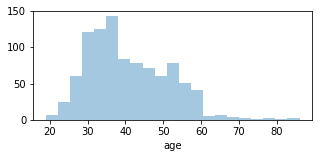

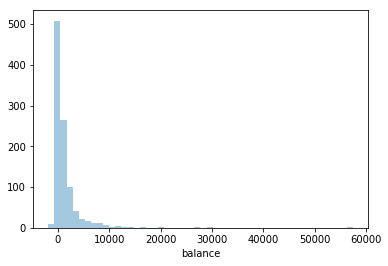

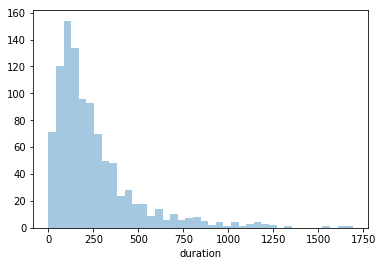

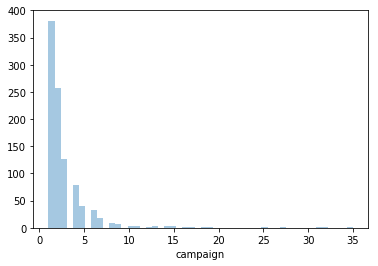

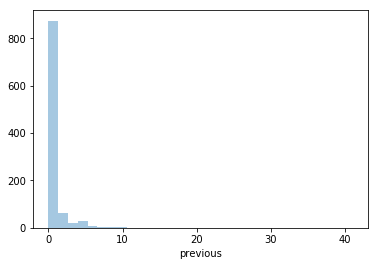

In [0]:
plt.figure(figsize=(5,2))
for col in vbles_num_def:
  sample_data = bank.select(col).sample(False, fraction=1000/filas).toPandas()
  sns.distplot(sample_data[col], kde=False)
  plt.show()

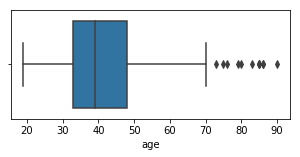

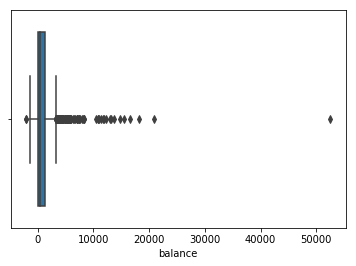

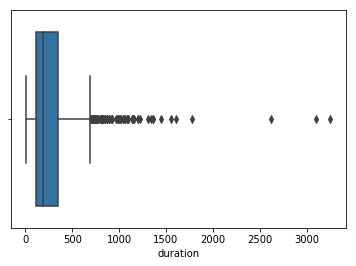

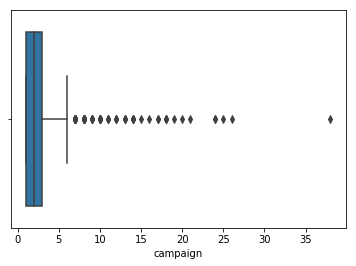

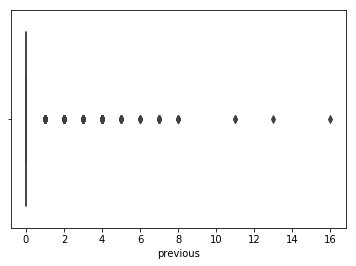

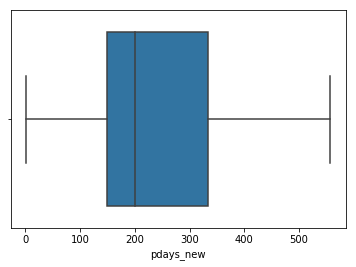

In [0]:
plt.figure(figsize=(5,2))
for col in vbles_num:
  sample_data = bank.select(col).sample(False, fraction=1000/filas).toPandas()
  sns.boxplot(sample_data[col], orient='h')
  plt.show()

In [0]:
bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+--------+--------+--------+--------+------------+----------+---------+
|age|         job| marital|education|default|balance|housing|loan|contact|duration|campaign|previous|poutcome|term_deposit|  new_date|pdays_new|
+---+------------+--------+---------+-------+-------+-------+----+-------+--------+--------+--------+--------+------------+----------+---------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|     261|       1|       0| unknown|          no|2008-05-05|     null|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|     151|       1|       0| unknown|          no|2008-05-05|     null|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|      76|       1|       0| unknown|          no|2008-05-05|     null|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|      92|       1|       0| unknown|          no|2008-05

In [0]:
def tukey_outliers(df, col):
    """
    Nos quedamos con los outliers para analizarlos
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 1.5 * IQR
    max_thresh = q3 + 1.5 * IQR
    
    #df_no_outliers = df.filter(~F.col(col).between(min_thresh, max_thresh))
    df_out = df.withColumn(col + '_is_outlier',F.when(F.col(col).between(min_thresh, max_thresh), 'normal').otherwise('out'))
    
    return df_out

In [0]:
outliers = bank
for col in vbles_num:
  outliers = tukey_outliers(outliers, col)
outliers.show(4)

+---+------------+-------+---------+-------+-------+-------+----+-------+--------+--------+--------+--------+------------+----------+---------+--------------+------------------+-------------------+-------------------+-------------------+--------------------+
|age|         job|marital|education|default|balance|housing|loan|contact|duration|campaign|previous|poutcome|term_deposit|  new_date|pdays_new|age_is_outlier|balance_is_outlier|duration_is_outlier|campaign_is_outlier|previous_is_outlier|pdays_new_is_outlier|
+---+------------+-------+---------+-------+-------+-------+----+-------+--------+--------+--------+--------+------------+----------+---------+--------------+------------------+-------------------+-------------------+-------------------+--------------------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|     261|       1|       0| unknown|          no|2008-05-05|     null|        normal|            normal|             normal|             normal|      

In [0]:
#nos quedamos con los campos creados outliers para seleccionar los outliers

outs = [col for col in outliers.columns if '_is_outlier' in col]
outs

['age_is_outlier',
 'balance_is_outlier',
 'duration_is_outlier',
 'campaign_is_outlier',
 'previous_is_outlier',
 'pdays_new_is_outlier']

In [0]:
#analizamos los outliers
for col in outs:
  print(col)
  tot_out_col = outliers.filter(F.col(col) == 'out').groupby('term_deposit').count()
  #tot_out_col.show()
  tot_col = outliers.filter(F.col(col) == 'out').select(col).count()
  prueba=tot_out_col.withColumn('pct',F.round((F.col('count')/tot_col)*100))
  prueba.show()


age_is_outlier
+------------+-----+----+
|term_deposit|count| pct|
+------------+-----+----+
|          no|  212|56.0|
|         yes|  169|44.0|
+------------+-----+----+

balance_is_outlier
+------------+-----+----+
|term_deposit|count| pct|
+------------+-----+----+
|          no| 4074|84.0|
|         yes|  798|16.0|
+------------+-----+----+

duration_is_outlier
+------------+-----+----+
|term_deposit|count| pct|
+------------+-----+----+
|          no| 1644|49.0|
|         yes| 1690|51.0|
+------------+-----+----+

campaign_is_outlier
+------------+-----+----+
|term_deposit|count| pct|
+------------+-----+----+
|          no| 2903|95.0|
|         yes|  161| 5.0|
+------------+-----+----+

previous_is_outlier
+------------+-----+----+
|term_deposit|count| pct|
+------------+-----+----+
|          no| 6352|77.0|
|         yes| 1905|23.0|
+------------+-----+----+

pdays_new_is_outlier
+------------+-----+----+
|term_deposit|count| pct|
+------------+-----+----+
|          no|33603|91

####Los outliers de age y duration se podrían eliminar porque no aportan información con respecto a la variable objetivo

###Análisis de variables categóricas

In [0]:
bankfulldeposit1 = bank.filter((F.col('term_deposit')=='yes'))
bankfulldeposit2 = bank.filter((F.col('term_deposit')=='no'))

Text(0.5, 1.0, 'DEPOSIT NO')

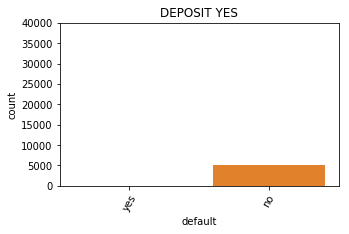

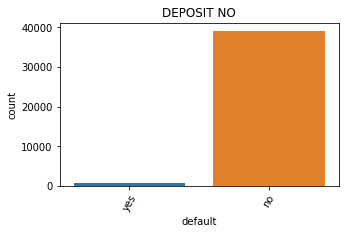

In [0]:
value_counts1 = bankfulldeposit1.groupBy('default').count().alias('deposit yes').toPandas()
value_counts2 = bankfulldeposit2.groupBy('default').count().alias('deposit no').toPandas()
value_counts1 = value_counts1.sort_values('count')
value_counts2 = value_counts2.sort_values('count')

plt.figure(figsize=(5,3))
sns.barplot(value_counts1['default'], value_counts1['count'])
plt.xticks(rotation=60)
plt.title('DEPOSIT YES')
plt.ylim(top=40000)

plt.figure(figsize=(5,3))
sns.barplot(value_counts2['default'], value_counts2['count'])
plt.xticks(rotation=60)
plt.title('DEPOSIT NO')

#### Hemos estudiado la relación entre la variable impago y depósitos y la conclusión es que el que tiene default, no tiene depósito contratado.

In [0]:
value_counts1 = bankfulldeposit1.groupBy('education').count().alias('deposit yes').toPandas()
value_counts2 = bankfulldeposit2.groupBy('education').count().alias('deposit no').toPandas()
value_counts1 = value_counts1.sort_values('count')
value_counts2 = value_counts2.sort_values('count')

Text(0.5, 1.0, 'DEPOSIT NO')

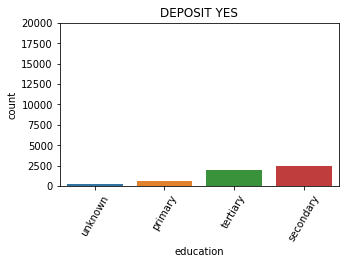

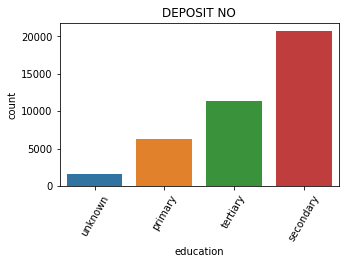

In [0]:
plt.figure(figsize=(5,3))
sns.barplot(value_counts1['education'], value_counts1['count'])
plt.xticks(rotation=60)
plt.ylim(top=20000)
plt.title('DEPOSIT YES')

plt.figure(figsize=(5,3))
sns.barplot(value_counts2['education'], value_counts2['count'])
plt.xticks(rotation=60)
plt.title('DEPOSIT NO')

####Hemos analizado las variables categóricas y su comportamiento respecto a la variable objetivo.
En el caso de la variable educación, lo que vemos es que tanto los que contratan el depósito como los que no, tienen educación de secundaria

In [0]:
value_counts1 = bankfulldeposit1.groupBy('job').count().alias('deposit yes').toPandas()
value_counts2 = bankfulldeposit2.groupBy('job').count().alias('deposit no').toPandas()
value_counts1 = value_counts1.sort_values('count')
value_counts2 = value_counts2.sort_values('count')

Text(0.5, 1.0, 'DEPOSIT NO')

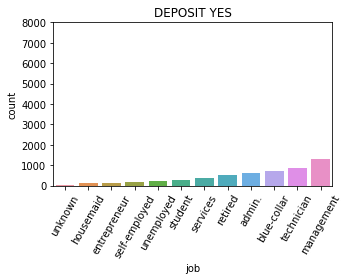

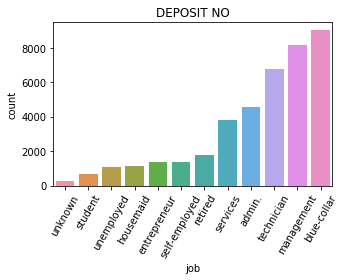

In [0]:
plt.figure(figsize=(5,3))
sns.barplot(value_counts1['job'], value_counts1['count'])
plt.xticks(rotation=60)
plt.ylim(top=8000)
plt.title('DEPOSIT YES')

plt.figure(figsize=(5,3))
sns.barplot(value_counts2['job'], value_counts2['count'])
plt.xticks(rotation=60)
plt.title('DEPOSIT NO')


####Los que contratan depósitos son del colectivo MANAGEMENT, mientras que el colectivo BLUE COLLAR  es el mayoritario en el caso de los que NO contratan depositos.

###Análisis Multivariante de las vbles cuantitativas
Para analizar la relación entra variables continuas se utilizan las correlaciones

In [0]:
print(quantitative_vars)
vbles_num_def = [col for col in vbles_num if 'pdays_new' != col]
vbles_num_def

['age', 'balance', 'duration', 'campaign', 'previous', 'pdays_new']


['age', 'balance', 'duration', 'campaign', 'previous']

In [0]:
corr_matrix = Statistics.corr(bank.select(quantitative_vars).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix #Calcula corr sobre RDDs con Vectors

array([[ 1.        ,  0.09778274, -0.00464843,  0.00476031,  0.00128832,
                nan],
       [ 0.09778274,  1.        ,  0.02156038, -0.01457828,  0.01667364,
                nan],
       [-0.00464843,  0.02156038,  1.        , -0.0845695 ,  0.00120306,
                nan],
       [ 0.00476031, -0.01457828, -0.0845695 ,  1.        , -0.03285529,
                nan],
       [ 0.00128832,  0.01667364,  0.00120306, -0.03285529,  1.        ,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
         1.        ]])

In [0]:
corr_matrix = pd.DataFrame(corr_matrix, columns=vbles_num_def, index=vbles_num_def)
corr_matrix

,age,balance,duration,campaign,previous
age,NaN,NaN,NaN,NaN,NaN
balance,0.097783,NaN,NaN,NaN,NaN
duration,-0.004648,0.021560,NaN,NaN,NaN
campaign,0.004760,-0.014578,-0.084570,NaN,NaN
previous,0.001288,0.016674,0.001203,-0.032855,NaN


In [0]:
#Calcula corr sobre RDDs con Vectors
%matplotlib inline
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

In [0]:
corr_matrix = corr_matrix.mask(mask)
corr_matrix


,age,balance,duration,campaign,previous
age,NaN,NaN,NaN,NaN,NaN
balance,0.097783,NaN,NaN,NaN,NaN
duration,-0.004648,0.021560,NaN,NaN,NaN
campaign,0.004760,-0.014578,-0.084570,NaN,NaN
previous,0.001288,0.016674,0.001203,-0.032855,NaN


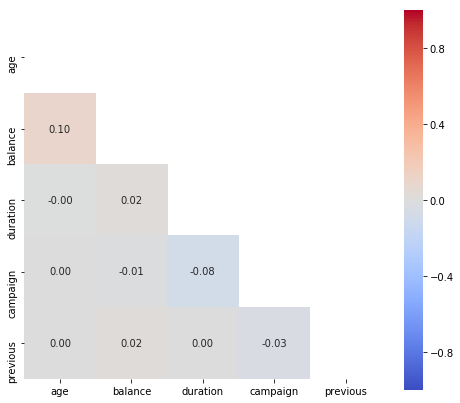

In [0]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')


#####Analizamos la correlación de las variables, vemos que en general está poco relacionadas, valores por debajo del 0,25. Esto significa que son variables candidatas a predecir el modelo

##RECALCULAR DIMENSIONES DEL DATASET
ORIGINAL: 

In [0]:
print(len_original)

(45211, 20)


In [0]:
bank.count(), len(bank.columns)


(45205, 16)

####picked up call, dates (year, month y day y creamons una nueva), y extra info.
####6 registros menos por inconsistentes.

## Conclusiones
###En cuanto a las variables numéricas y tras analizar la distribución de lo datos, vemos que balance y campaign pueden ser interesantes para predecir la contratación del depósito.
###Respecto a las categóricas hemos analizado la relación entre los impagos, education y jobs con la variable objetivo y concluimos que éstas también pueden ayudar a predecir la contratacion del depósito.